# 0. Loading the libraries

In [1]:
import scanpy as sc
import numpy as np
# import matplotlib.pyplot as plt

In [2]:
# parameters for better quality in regards to poster/paper graphics
sc.settings.verbosity = 3
sc.settings.figdir='../Results/figures/alldata/'
sc.settings.file_format_figs='pdf'
sc.settings.plot_suffix='_all_data'
sc.settings.autoshow=True
sc.set_figure_params(dpi=200, dpi_save=300, fontsize=10)

# 1. Reading in the data


In [3]:
fp = '../Data/all/data.h5ad'
data = sc.read(fp, cache=True)

After reading in and annotating the data, an overview of the data follows:

In [4]:
# Checking the total size of the dataset
data.shape

(43738, 22021)

In [5]:
# Checking all celltypes existing in the dataset
set(data.obs['cell_type'])

{'cd4+',
 'cd8+',
 'malignant',
 'mono',
 'nk',
 'nlc',
 'not_annotated',
 'unassigned'}

In [6]:
for cluster in set(data.obs['cluster']):
    c = data[data.obs['cluster'] == cluster]
    print("Cluster ", cluster, ": Celltype ", set(c.obs['cell_type']))

Cluster  0 : Celltype  {'malignant'}
Cluster  1 : Celltype  {'malignant'}
Cluster  10 : Celltype  {'nlc'}
Cluster  11 : Celltype  {'unassigned'}
Cluster  12 : Celltype  {'not_annotated'}
Cluster  2 : Celltype  {'cd8+'}
Cluster  3 : Celltype  {'malignant'}
Cluster  4 : Celltype  {'malignant'}
Cluster  5 : Celltype  {'cd8+'}
Cluster  6 : Celltype  {'cd4+', 'unassigned'}
Cluster  7 : Celltype  {'malignant'}
Cluster  8 : Celltype  {'mono'}
Cluster  9 : Celltype  {'nk', 'unassigned'}


In [7]:
adata = data

# 2 Data exploration

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

In [9]:
adata.obs

,sample.name,patient,cluster,cell_type,patient.sample,n_counts,log_counts,n_genes,mt_frac
index,,,,,,,,,
0,38,6,1,malignant,6000,2867.0,7.961021,1062,0.045344
1,144,6,1,malignant,6000,2236.0,7.712444,922,0.046064
2,385,6,3,malignant,6000,3122.0,8.046229,1252,0.020179
3,564,6,9,unassigned,6000,2254.0,7.720462,986,0.039485
4,1567,6,8,mono,6000,2872.0,7.962764,1027,0.042131
...,...,...,...,...,...,...,...,...,...
43733,8846363,5,2,cd8+,5150,1122.0,7.022868,513,0.016934
43734,8846413,5,8,mono,5150,579.0,6.361302,343,0.032815
43735,8846447,5,2,cd8+,5150,1064.0,6.969790,527,0.017857


In [10]:
a = list(adata.obs['n_counts'])
print("Counts range from ", min(a), " to ", max(a))

Counts range from  253.0  to  30419.0


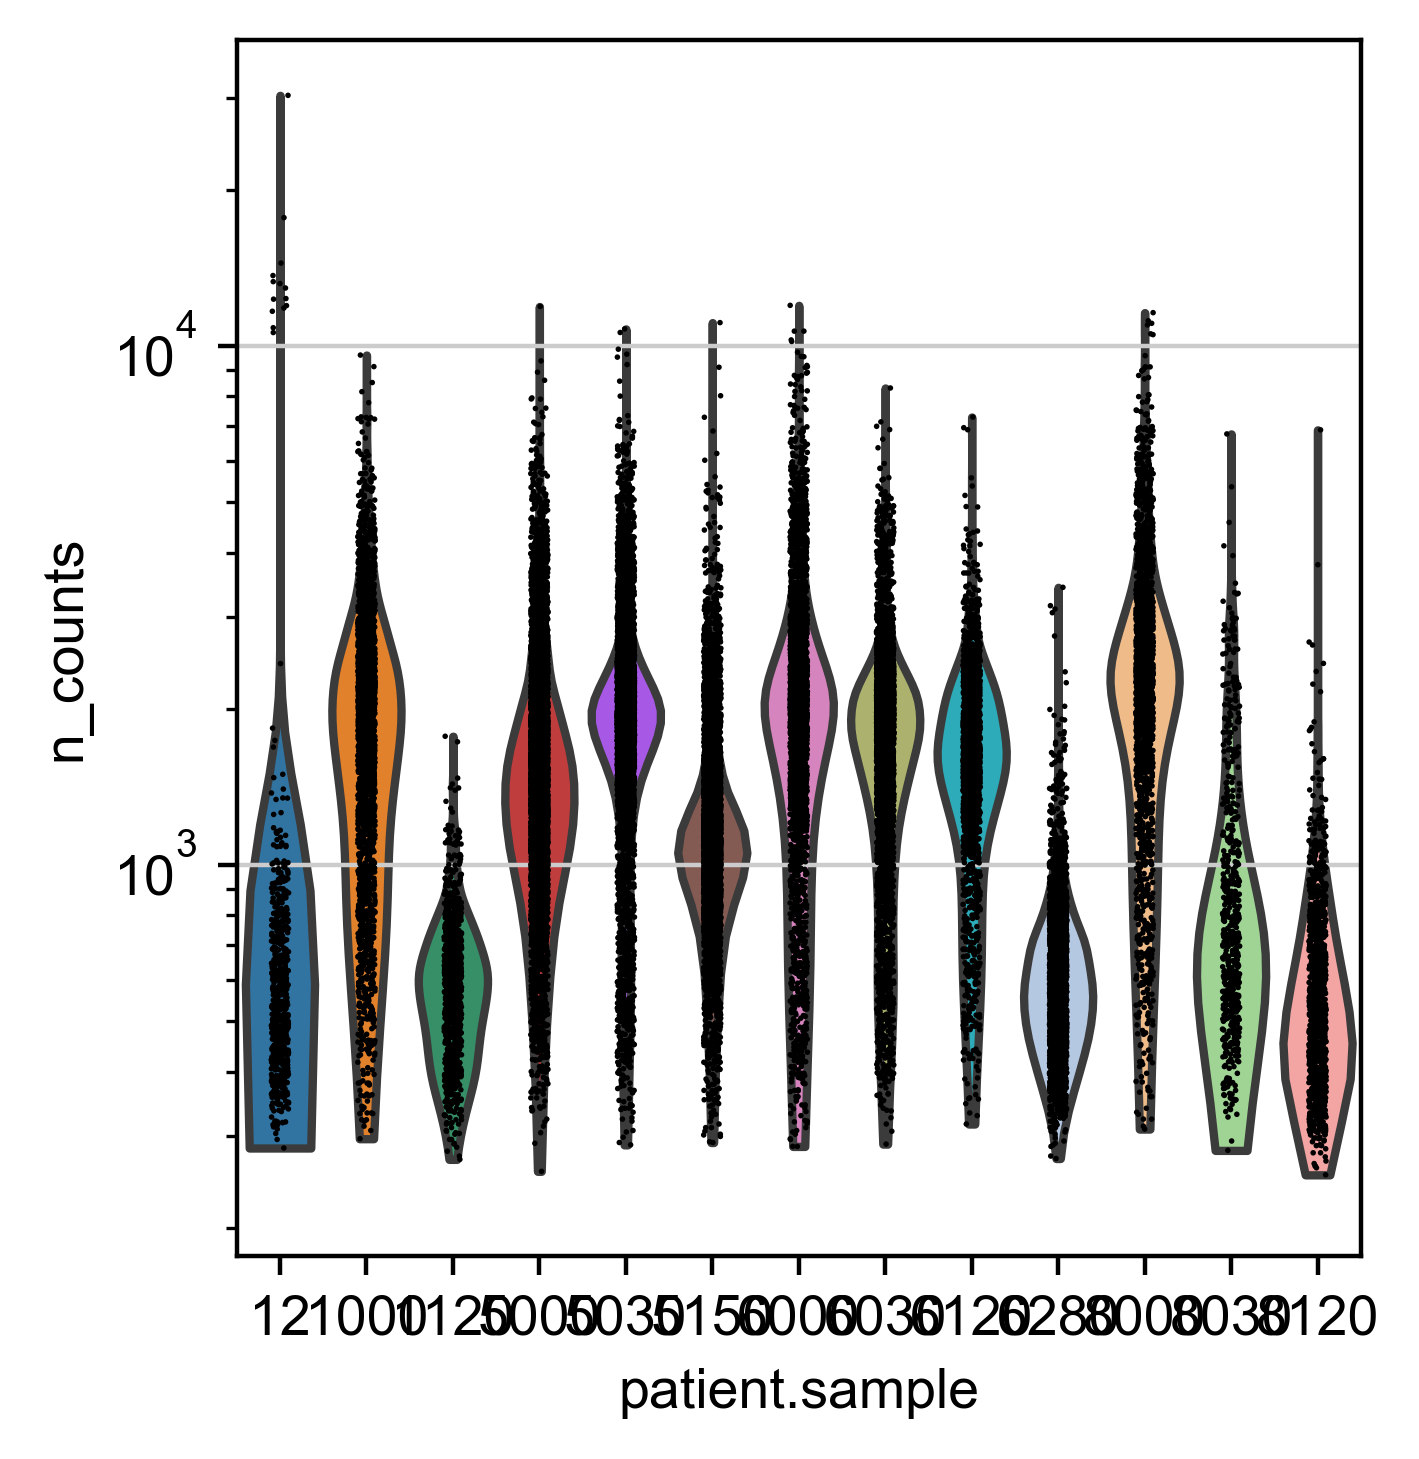

saving figure to file ../Results/figures/alldata/violin_patientsample_mtfrac_all_data.pdf


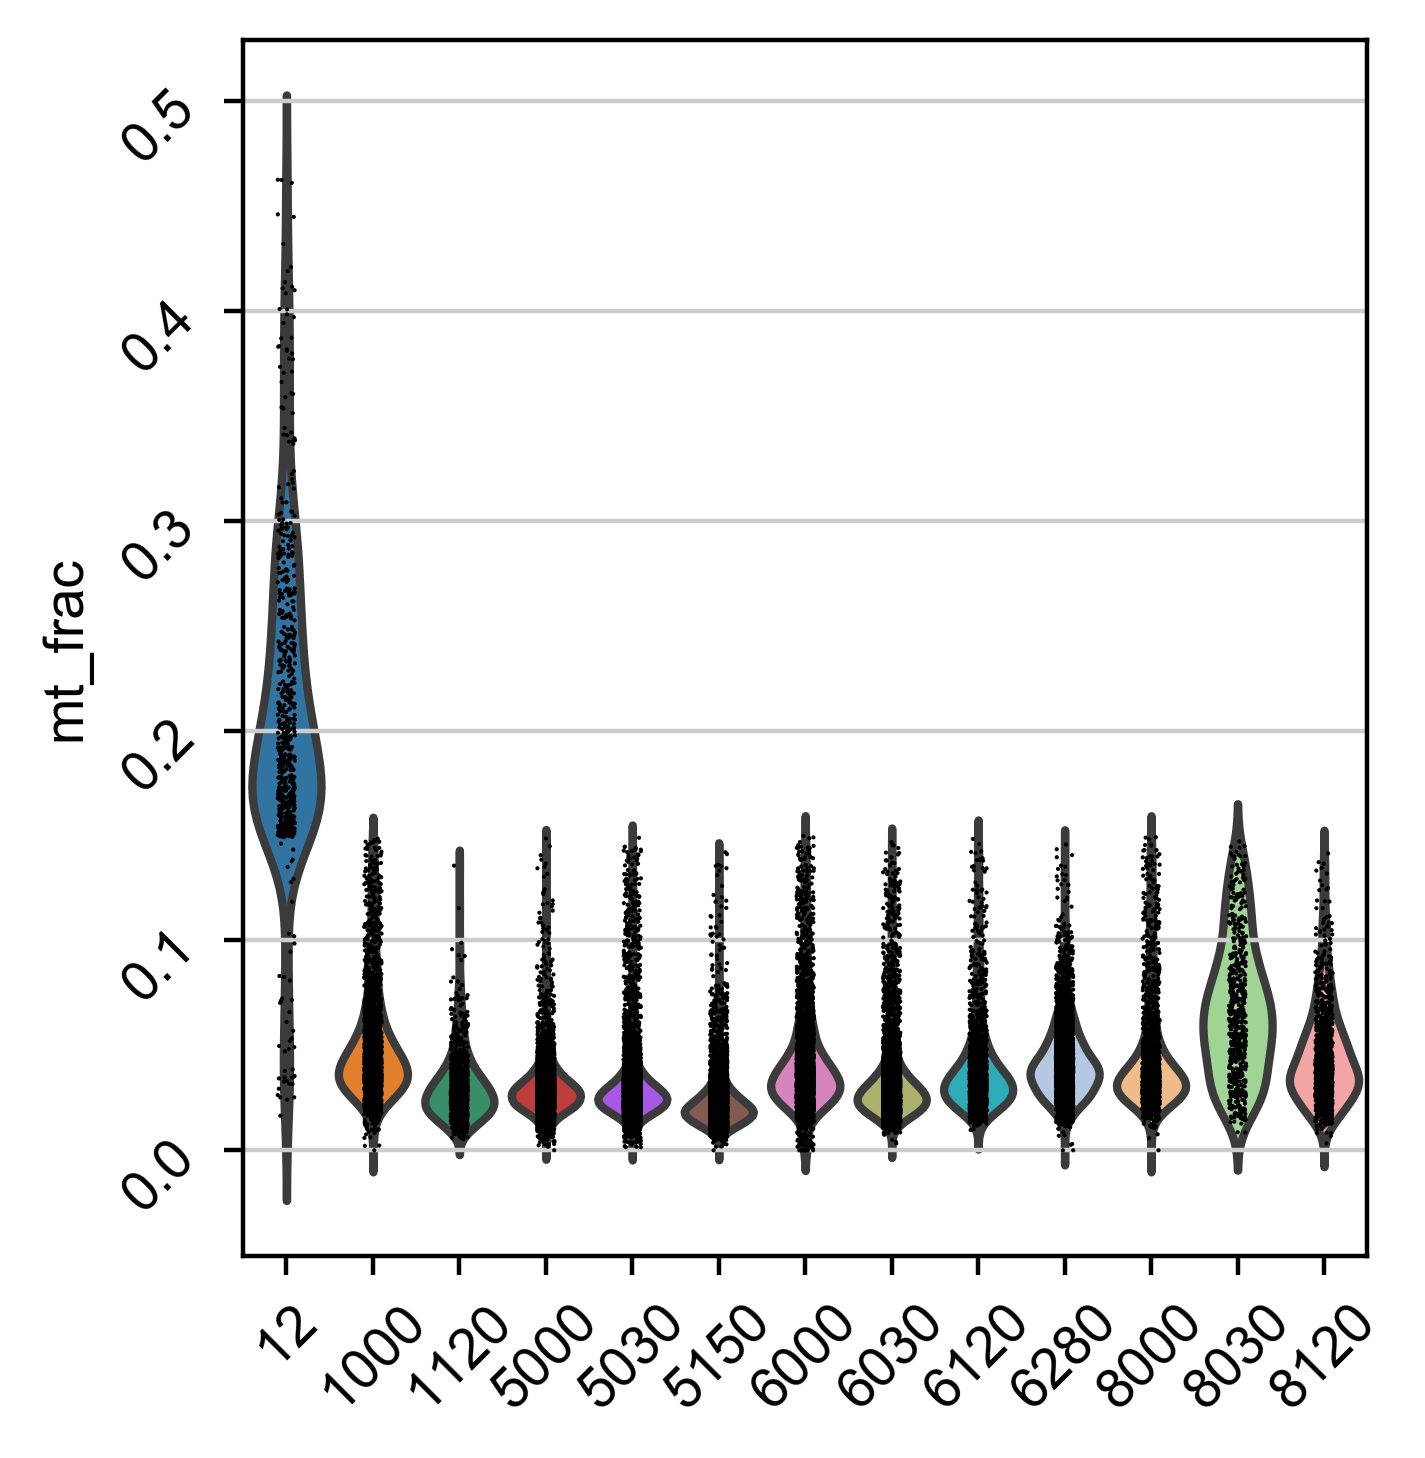

In [11]:
t1 = sc.pl.violin(adata, 'n_counts', groupby='patient.sample', log=True, cut=0, edgecolor='none')
t2 = sc.pl.violin(adata, 'mt_frac', groupby='patient.sample', size=0.75, rotation=45, save='_patientsample_mtfrac')

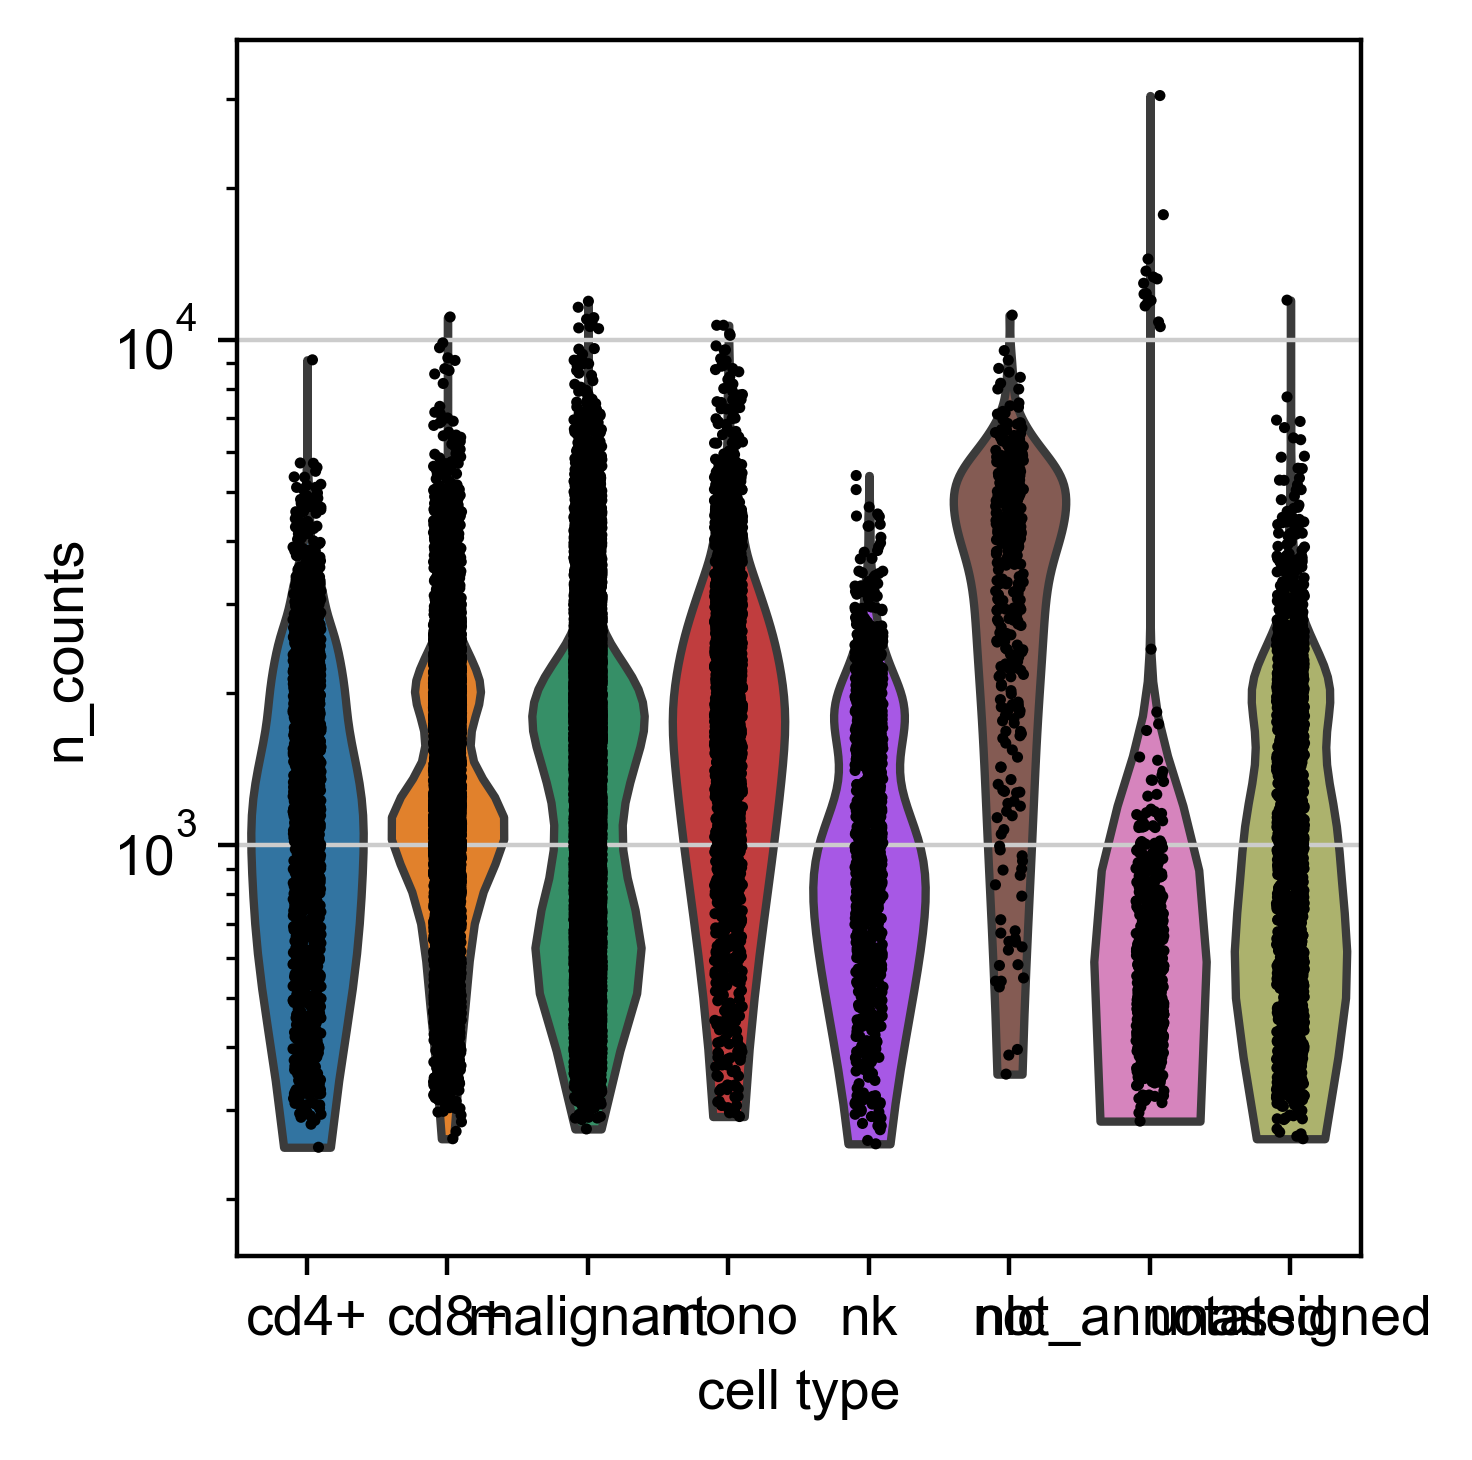

saving figure to file ../Results/figures/alldata/violin_celltype_mtfrac_all_data.pdf


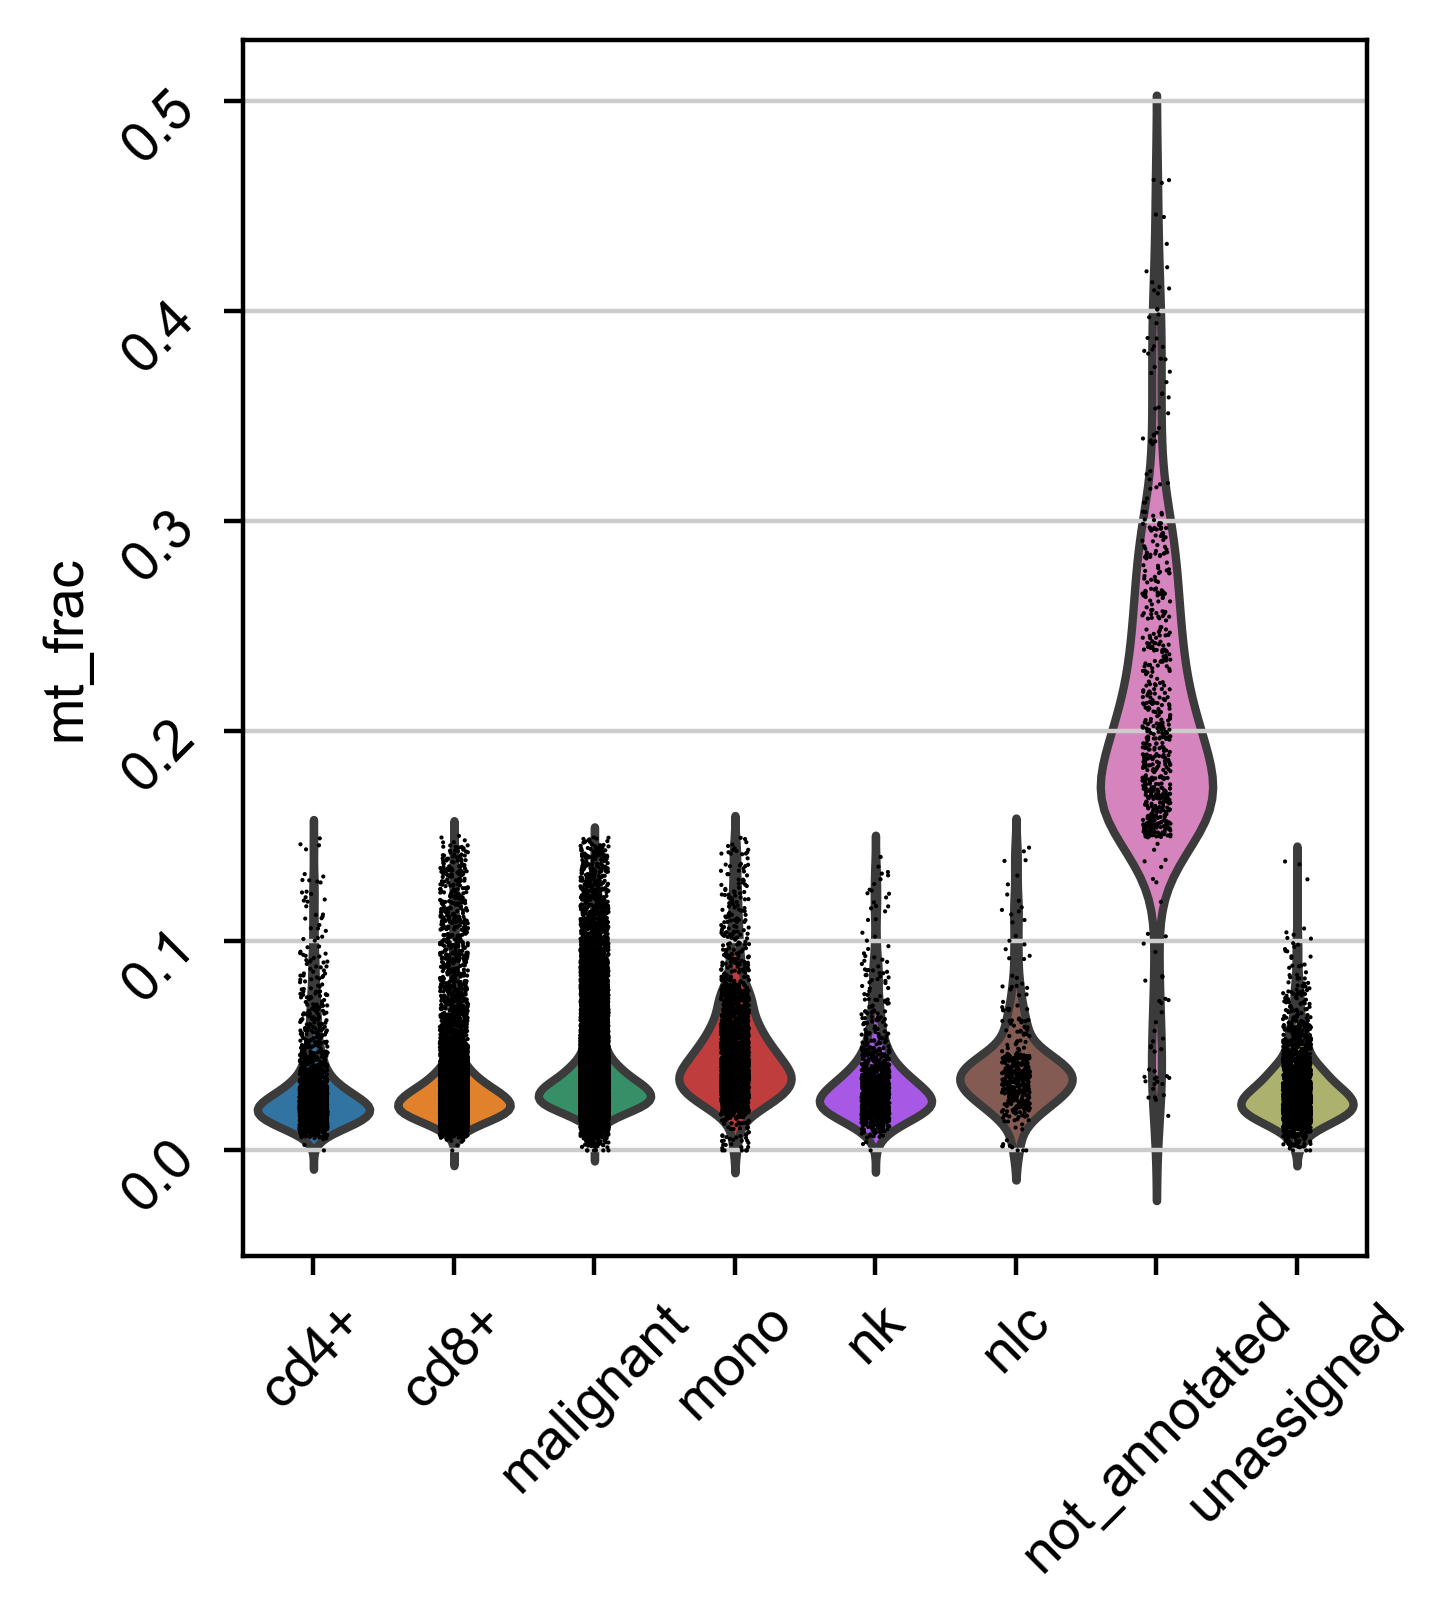

In [13]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='cell_type', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='cell_type', size=0.75, rotation=45, save='_celltype_mtfrac')

As the violin plots for patient sample 12 and not_annotated celltype show, the count number is low and the resulting mitochondrial gene count ratio is for most cells over 15%. Indeed all the cells of patient sample 12 are of not_annotated celltype

In [14]:
print(data[data.obs['patient.sample'] == "12"].obs['cell_type'].value_counts())
print(data[data.obs['cell_type'] == "not_annotated"].obs['patient.sample'].value_counts())

not_annotated    669
Name: cell_type, dtype: int64
12    669
Name: patient.sample, dtype: int64


# 3. Subsetting

In [15]:
subset = data[data.obs['cell_type'].isin(['cd4+', 'cd8+', 'mono', 'nk', 'nlc', 'unassigned'])]
subset.write('../Data/selection/celltype_selection.h5ad')

We subset the original data and exclude cells with celltype labels "malignant" and "not_annotated".

'malignant' celltype is excluded as our source for marker genes (genemarker.com) does not include markers for 'malignant' PBMCs.
'not_annotated' celltype is excluded as data exploration showed that 'not_annotated' cells have a low count number and a mitochondrial gene count ratio of mostly over 15% - and the corresponding patient sample "12" is not existent in the original data.

We store the subsetted data in h5 file format.